sources are based on: https://github.com/AllenInstitute/MicronsBinder/tree/master/notebooks/mm3_intro 

# setting up workspace

In [1]:
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import scipy as sp
import scipy.spatial as sci_spatial
from scipy.spatial import distance_matrix
from tqdm import tqdm
import csv
import pickle #how to use pickle: https://www.datacamp.com/tutorial/pickle-python-tutorial 
import matplotlib.pyplot as plt
from nglui import statebuilder
import plotly.figure_factory as ff
import networkx as nx
from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram

client = CAVEclient()

In [2]:
#load up the dataset through query # no query for minnie35: https://github.com/seung-lab/CAVEclient/issues/49 
client = CAVEclient('minnie65_public_v117') #minnie65_public_v117
# client2 = CAVEclient('minnie35_public_v0 ')

In [3]:
#view the tables we can query from the materialization engine
client.materialize.get_tables()

['nucleus_detection_v0',
 'synapses_pni_2',
 'nucleus_neuron_svm',
 'proofreading_status_public_release',
 'func_unit_em_match_release',
 'allen_soma_ei_class_model_v1',
 'allen_visp_column_soma_coarse_types_v1']

working to connect the pre-post synaptic graph. source: https://github.com/AllenInstitute/MicronsBinder/blob/master/notebooks/mm3_intro/SynapseAndAnnotationQuery.ipynb 

In [4]:
# Load all the proofreaded neurons (with different proofreadbility)
prf_df=client.materialize.query_table('proofreading_status_public_release')

statuses_axon = pd.Series(prf_df.loc[:,"status_axon"])

raw_valid_ids = pd.Series(prf_df.loc[:,"valid_id"])

valid_ids = []
for i in range(len(statuses_axon)):
    if statuses_axon[i] != "non":
        valid_ids.append(raw_valid_ids[i])
print(len(valid_ids))

249


In [5]:
# verify that pt_root_id == valid_id for clean axons
verified_ids_len = 0 
for i in range(len(valid_ids)):
    verified_ids_len += 1
print('verified_ids_len', verified_ids_len)

verified_ids_len 249


In [6]:
# setting up str_num_2_presypneuron and presypneuron_2_str_num to simplify the representation of pre-syp-neuron-id
# using string number (e.g.: "20") to correspond to the long-digit id of the pre-syp-neuron 
num_rep_2_presypneuron = {}
presypneuron_2_num_rep = {}
for i, the_id in enumerate(valid_ids):
    num_rep_2_presypneuron[i] = the_id
    presypneuron_2_num_rep[the_id] = i

# working on sheezneat

In [7]:
#creating 1. syp_dict 2. syp_positions (n by 3 matrix) 3. syp_pos_tracking that has the syp id 
pt_root_ids = valid_ids
syp_pos_tracking = []

infile_syp_dict = open('syp_dict','rb')
syp_dict = pickle.load(infile_syp_dict)
infile_syp_dict.close()

infile_syp_xyz_pos = open('syp_xyz_pos','rb')
syp_xyz_pos = pickle.load(infile_syp_xyz_pos)
infile_syp_xyz_pos.close()

infile_syp_pos_tracking = open('syp_pos_tracking', 'rb')
syp_pos_tracking = pickle.load(infile_syp_pos_tracking)
infile_syp_pos_tracking.close()

In [8]:
#load up the seqs with post neuron list and syp ids of seqs with post neuron list 
infile_seqs_with_post_neuron_lst_5um = open('seqs_with_post_neuron_lst_5um','rb')
seqs_with_post_neuron_lst = pickle.load(infile_seqs_with_post_neuron_lst_5um)
infile_seqs_with_post_neuron_lst_5um.close()

infile_syp_ids_of_seqs_with_post_neuron_lst_5um = open('syp_ids_of_seqs_with_post_neuron_lst_5um','rb')
syp_ids_of_seqs_with_post_neuron_lst = pickle.load(infile_syp_ids_of_seqs_with_post_neuron_lst_5um)
infile_syp_ids_of_seqs_with_post_neuron_lst_5um.close()

In [9]:
def get_seq_with_length_n_of_unique_keys_for_occur_more_than_m_times_w_type_lst(n, m, dict_with_certain_type):
    seq_keys_for_more_than_n_occur_lst = []
    seq_keys_for_more_than_n_occur = filter(lambda key: len(key)== n and len(dict_with_certain_type[key]) > m , dict_with_certain_type)
    for key in seq_keys_for_more_than_n_occur:
        seq_keys_for_more_than_n_occur_lst.append(key)
        
    unique_neurons_with_more_n_occur_w_type_lst = {}
    for key in seq_keys_for_more_than_n_occur_lst:
        has_occurred = set()
        instance_tuple = key
        instance_list = list(instance_tuple)
        has_occurred.add(instance_list[0])
        for i in range(1, len(instance_list)):
            neuron_i = instance_list[i]
            if neuron_i in has_occurred:
                continue
            else: 
                has_occurred.add(neuron_i)
        if len(has_occurred) == len(instance_tuple):
            unique_neurons_with_more_n_occur_w_type_lst[instance_tuple] = dict_with_certain_type[instance_tuple]
    return unique_neurons_with_more_n_occur_w_type_lst

In [10]:
# seq_keys = filter(lambda key: len(key)==3, seqs_with_post_neuron_lst)
# for key in seq_keys:
#     print(key, len(seqs_with_post_neuron_lst[key]))

In [11]:
# seq_keys_for_more_than_one_occur_lst = []
# seq_keys_for_more_than_one_occur = filter(lambda key: len(key)==3 and len(seqs_with_post_neuron_lst[key]) >=2 , seqs_with_post_neuron_lst)
# for key in seq_keys_for_more_than_one_occur:
#     seq_keys_for_more_than_one_occur_lst.append(key)
#     print(key, len(seqs_with_post_neuron_lst[key]))

In [12]:
len_3_seq_morethan_1_time_w_post_neuron_lst = get_seq_with_length_n_of_unique_keys_for_occur_more_than_m_times_w_type_lst(3, 1, seqs_with_post_neuron_lst)
len_3_seq_morethan_1_time_w_syp_ids_lst = get_seq_with_length_n_of_unique_keys_for_occur_more_than_m_times_w_type_lst(3, 1, syp_ids_of_seqs_with_post_neuron_lst)

# scanning for potential ABC-CBA palindrom in seq with unique elements

In [13]:
# ssss = ['a','b','c']
# for i in range(len(ssss) -1, -1, -1):
#     print(ssss[i])

In [14]:
# lllst = [('a','b','c'), ('c','b','a'), ('d','e','f'), (1,2,3), (3,2,1)]
# unique_forward_triplet_set = set()
# scan_count = 0 
# duality_triplet_count = 0
# for triplet_tup_fm in lllst:
#     triplet_lst_fm = list(triplet_tup_fm)
#     forward_lst_fm = []
#     for i in range(len(triplet_lst_fm)-1, -1, -1):
#         forward_lst_fm.append(triplet_lst_fm[i])
#     if tuple(forward_lst_fm) in unique_forward_triplet_set:
#         duality_triplet_count += 1
#         scan_count += 1
#     else:
#         unique_forward_triplet_set.add(triplet_tup_fm)
#         scan_count += 1
# print(scan_count)
# print(duality_triplet_count)

In [15]:
preneuron_triplets_lst = list(len_3_seq_morethan_1_time_w_syp_ids_lst.keys())
unique_forward_triplet_set = set()
scan_count = 0 
duality_triplet_count = 0
for triplet_tup_fm in preneuron_triplets_lst:
    triplet_lst_fm = list(triplet_tup_fm)
    forward_lst_fm = []
    for i in range(len(triplet_lst_fm)-1, -1, -1):
        forward_lst_fm.append(triplet_lst_fm[i])
    if tuple(forward_lst_fm) in unique_forward_triplet_set:
        duality_triplet_count += 1
        scan_count += 1
    else:
        unique_forward_triplet_set.add(triplet_tup_fm)
        scan_count += 1
    

In [16]:
print(scan_count)
print(duality_triplet_count)

22
0


# neuroglancer visual check

In [17]:
# # automating the NG rendering process
# # colors = ['#800000', '#008000', '#008080', '#FFFFFF'] # the post neuron has the white color 
# points = statebuilder.PointMapper(point_column='pt_position')
# anno_layer = statebuilder.AnnotationLayerConfig(name='annos',
#                                    mapping_rules=points)
# image_path = 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em'
# segmentation_path = 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie65_public_v117'
# img = statebuilder.ImageLayerConfig(image_path)

# # preneurons of interest, the postneuron, and the syps  
# render_urls = []
# url_collections = {} #key: (preneurons + a postneuron); value: url
# ttl_count = 0 
# with tqdm(total= len(list(len_3_seq_morethan_1_time_w_post_neuron_lst.keys()))) as pbar:
#     for key in list(len_3_seq_morethan_1_time_w_post_neuron_lst.keys()):
#         pbar.update(1)
#         preneurons_ids = []
#         preneurons_ids += list(key)
#         for i, post_neuron in enumerate(len_3_seq_morethan_1_time_w_post_neuron_lst[key]):
#             ids_of_neurons = []
#             ids_of_neurons += list(key)
#             ids_of_neurons.append(post_neuron)
#             syps = len_3_seq_morethan_1_time_w_syp_ids_lst[key][i]
#             syps_of_interest = list(syps)
#             syp_voxel_pos_lst = []
#             for j, preneuron in enumerate(preneurons_ids):
#                 untouched_output_df = client.materialize.synapse_query(pre_ids = preneuron)
#                 syp_id = syps_of_interest[j]
#                 syp_id_info_in_df = untouched_output_df.query('id == @syp_id')
#                 syp_voxel_pos = syp_id_info_in_df.loc[:,"ctr_pt_position"] #this gives a panda series and is a list of array
#                 syp_voxel_pos_lst_format = (list(syp_voxel_pos)[0]).tolist()
#                 syp_voxel_pos_lst.append(syp_voxel_pos_lst_format)
#             predf_data = {'syp_pos': syp_voxel_pos_lst}
#             syp_pos_df = pd.DataFrame(predf_data)

#             seg = statebuilder.SegmentationLayerConfig(name = 'seg65', 
#                                            source = segmentation_path,
#                                           fixed_ids = ids_of_neurons)
#             da_syp_points = statebuilder.PointMapper(point_column='syp_pos')
#             da_syp_anno_layer = statebuilder.AnnotationLayerConfig(name='syp_pos_annos',
#                                                mapping_rules=da_syp_points)
#             da_sb = statebuilder.StateBuilder([img, seg, da_syp_anno_layer])
#             url_type = da_sb.render_state(syp_pos_df, return_as='url')
#             render_urls.append(url_type)
#             url_collections[str(ids_of_neurons)] = url_type

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:32<00:00,  4.22s/it]


In [18]:
print(len(render_urls))
print(len(url_collections))

44
44


In [19]:
url_collections_pd = pd.DataFrame([{'neurons': key, 'url':value} for key, value in url_collections.items()])

In [20]:
url_collections_pd.to_csv('len_3_seq_all_uniqe_url_collections.csv')

# constructing 'pseudo tree' (with acyclic cycle) to capture occurence of each neuron

Unerstanding of linkage matrix:
1. https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

2. http://www.ece.northwestern.edu/local-apps/matlabhelp/toolbox/stats/linkage.html#:~:text=Description,vector%20with%20the%20pdist%20function.

3. https://stackoverflow.com/questions/9838861/scipy-linkage-format 

In [21]:
all_pre_neurons = list(seqs_with_post_neuron_lst.keys())

In [22]:
len(all_pre_neurons)

13623

In [23]:
print(len(num_rep_2_presypneuron))
print(len(presypneuron_2_num_rep))

249
249


In [24]:
co_occur_mat = np.zeros((len(num_rep_2_presypneuron), len(num_rep_2_presypneuron)))

In [25]:
# loop through the seqs in all_pre_neurons
# look into each of the entry of the triplet and update count of the "diagonally-symmetric" entries 
with tqdm(total= len(all_pre_neurons)) as pbar:
    for seq in all_pre_neurons:
        pbar.update(1)
        if len(seq) == 1:
            continue
        else:
            seq_len = len(seq)
            for i in range(seq_len):
                if not (i + 1) >= seq_len:
                    curr_neuron = seq[i]
                    next_neuron = seq[i+1]
                    curr_neuron_num_rep = presypneuron_2_num_rep[curr_neuron]
                    next_neuron_num_rep = presypneuron_2_num_rep[next_neuron]
                    co_occur_mat[curr_neuron_num_rep][next_neuron_num_rep] += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 13623/13623 [00:00<00:00, 251426.80it/s]


In [26]:
a = np.matrix([[1, 0, 1, 1], [1, 1, 0, 1], [0, 0, 0, 2], [3, 0, 0, 0]])

In [27]:
pd_a = sci_spatial.distance.pdist(a)

In [28]:
z = sp.cluster.hierarchy.linkage(pd_a)
print(z)

[[0.         1.         1.41421356 2.        ]
 [2.         4.         1.73205081 3.        ]
 [3.         5.         2.44948974 4.        ]]


In [29]:
# fig = ff.create_dendrogram(a)
# fig.update_layout(width=800, height=500)
# fig.show()

In [30]:
# sp.cluster.hierarchy.dendrogram(z)

In [31]:
# fig = ff.create_dendrogram(co_occur_mat)
# fig.update_layout(width=2300, height=1200)
# fig.show()

start with one instance loop through all the all_pre_neurons to find specific initiating (starting) preneuron

In [32]:
def update_neuron_occur_tracking(neuron_occur_tracking, the_neuron, curr_layer):
    neuron_occur_tracking[the_neuron] = curr_layer

In [33]:
seq = (864691136618559885, 864691135697462549, 864691135748826153)
seq_1 = (864691136618559885, 864691136618559885, 864691136618559885)
seq_2 = (864691136618559885, 864691135748826153, 864691135748826153)
seq_3 = (864691135428608048, 864691135415702458, 864691136577704980)
seq_4 = (864691135644850415,
  864691135753888205,
  864691135396580129)
# all_pre_neurons = [seq, seq, seq_1, seq_2, seq_3, seq_4]

In [34]:
print(presypneuron_2_num_rep[864691136618559885])
print(presypneuron_2_num_rep[864691135697462549])
print(presypneuron_2_num_rep[864691135748826153])

193
147
202


In [35]:
print(presypneuron_2_num_rep[864691135428608048])
print(presypneuron_2_num_rep[864691135644850415])

194
213


In [45]:
#construct dict to hold graphs; each graph starts with one of the 249 neurons. Thus, there will be 249 graphs
graphs = {}

for seq in all_pre_neurons:
    #set up a dictionary to track which layer each element is in the tree in this seq
    neuron_occur_tracking = {}
    
    a_graph = None 
    #start looking at the curr neuron and the its next neuron
    seq_len = len(seq)
    for i in range(seq_len):
        if i == 0: 
            curr_neuron = seq[i]
            curr_neuron_num_rep = presypneuron_2_num_rep[curr_neuron]
            if not curr_neuron_num_rep in graphs:
                graphs[curr_neuron_num_rep] = nx.Graph()
                a_graph = graphs[curr_neuron_num_rep]
            else:
                a_graph = graphs[curr_neuron_num_rep]
                
        if i + 1 == seq_len:
            curr_neuron = seq[i]
            update_neuron_occur_tracking(neuron_occur_tracking, curr_neuron, i)
            curr_neuron_tag = str(presypneuron_2_num_rep[curr_neuron]) + '_' + str(neuron_occur_tracking[curr_neuron])
            if a_graph.has_node(curr_neuron_tag):
                if len(a_graph.nodes[curr_neuron_tag]) == 0:
                    a_graph.nodes[curr_neuron_tag]['node_weight'] = 1
                else:
                    a_graph.nodes[curr_neuron_tag]['node_weight'] += 1
            else: 
                a_graph.add_node(curr_neuron_tag)
                a_graph.nodes[curr_neuron_tag]['node_weight'] = 1
            
        if not (i + 1) >= seq_len:
            curr_neuron = seq[i]
            next_neuron = seq[i+1]
            update_neuron_occur_tracking(neuron_occur_tracking, curr_neuron, i)
            
            #naming: 1_2: neuron 1 appear at 2nd layer 
            #need to "decrorate the neuron_tags a little bit more e.g. 1_1, 1_2, and 1_3 and so on"
            curr_neuron_tag = str(presypneuron_2_num_rep[curr_neuron]) + '_' + str(neuron_occur_tracking[curr_neuron])
            next_neuron_tag = None 
            if curr_neuron == next_neuron:
                next_neuron_tag = str(presypneuron_2_num_rep[curr_neuron]) + '_' + str(neuron_occur_tracking[curr_neuron] + 1)
            else:
                next_neuron_tag = str(presypneuron_2_num_rep[next_neuron]) + '_' + str(neuron_occur_tracking[curr_neuron] + 1)

            #check with the edge that connects curr & next neuron is presence in the existing network
            #use function to encap below
            if a_graph.has_edge(curr_neuron_tag, next_neuron_tag):
                a_graph.nodes[curr_neuron_tag]['node_weight'] += 1
            else:
                a_graph.add_edge(curr_neuron_tag, next_neuron_tag)
                if a_graph.has_node(curr_neuron_tag):
                    if len(a_graph.nodes[curr_neuron_tag]) == 0:
                        a_graph.nodes[curr_neuron_tag]['node_weight'] = 1
                    else:
                        a_graph.nodes[curr_neuron_tag]['node_weight'] += 1
                else: 
                    a_graph.add_node(curr_neuron_tag)
                    a_graph.nodes[curr_neuron_tag]['node_weight'] = 1
            #use function to encap above

In [46]:
a_graph = graphs[200]

In [47]:
# nx.get_node_attributes(a_graph,'node_weight')

In [48]:
list(a_graph.nodes())[0]

'200_0'

In [49]:
color_map = []
for node in a_graph:
    initial_node = list(a_graph.nodes())[0]
    if node == initial_node:
        color_map.append('red')
    else: 
        color_map.append('white')  

In [50]:
a_pos=nx.spring_layout(a_graph)

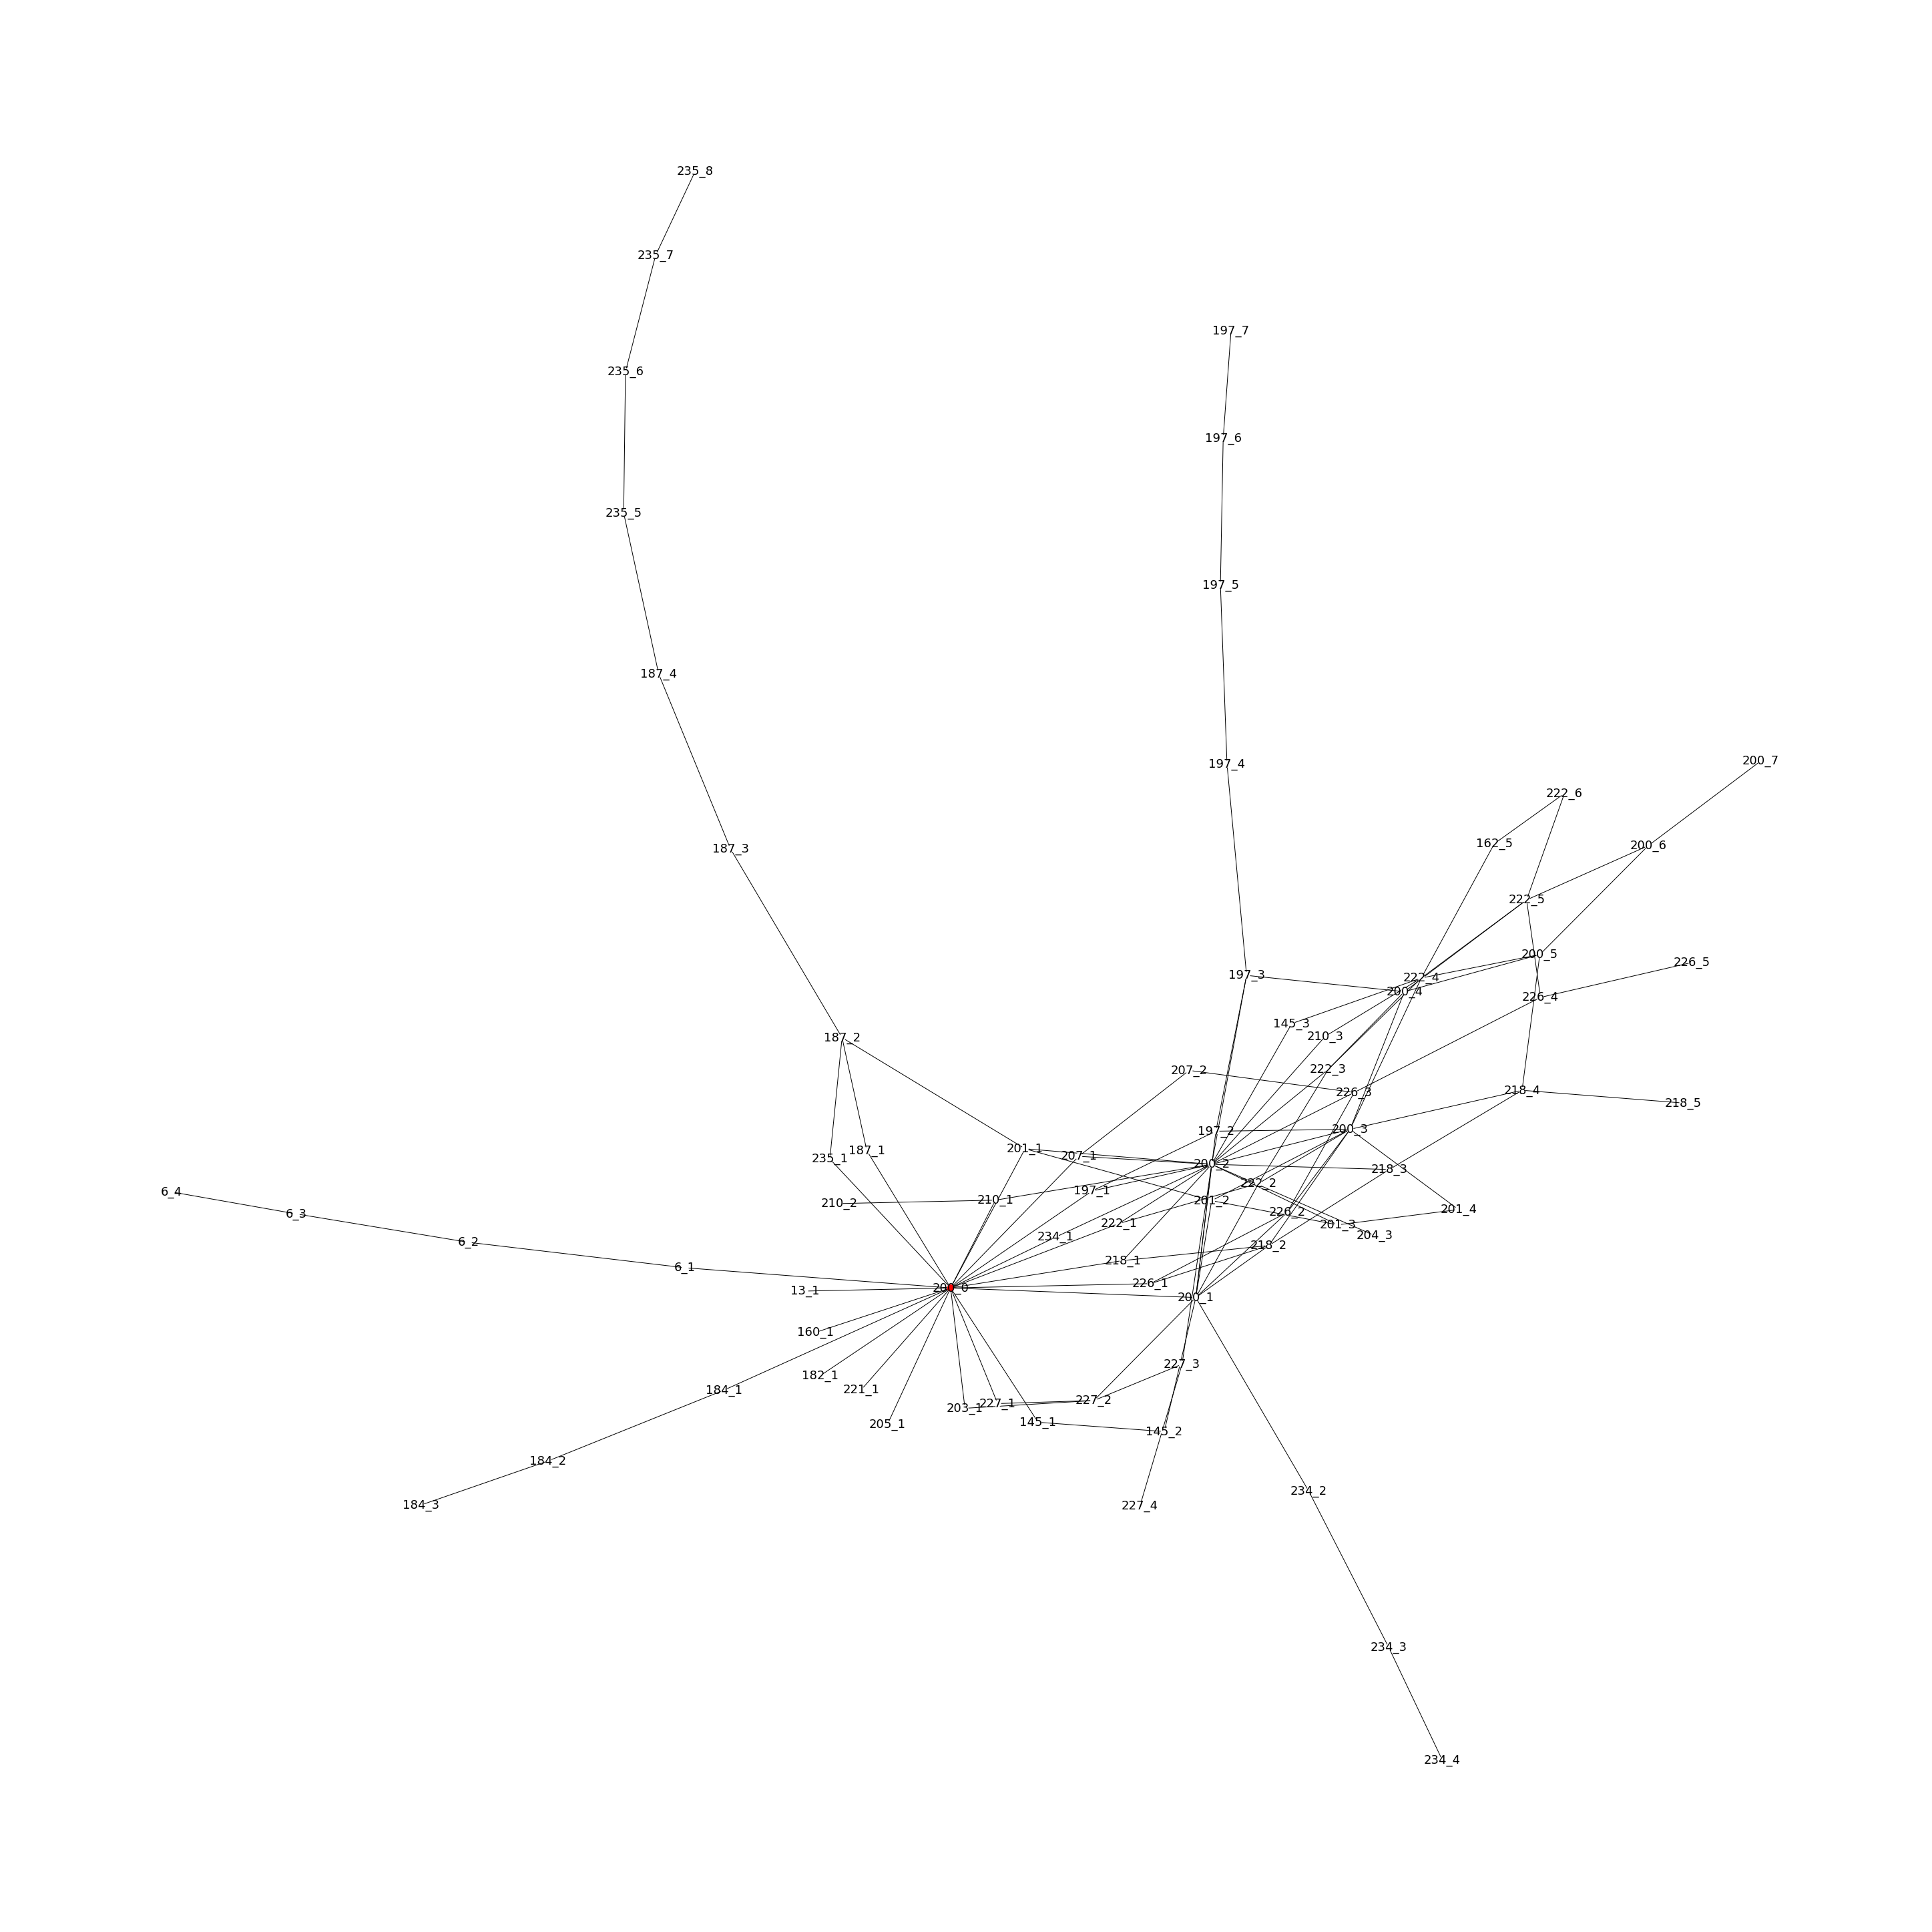

In [51]:
plt.figure(3,figsize=(40,40)) 
nx.draw(a_graph, node_color=color_map, with_labels = True, node_size=90,font_size=18)
# plt.savefig("./dir_for_trees/Graph1.png", format="PNG")
plt.show()


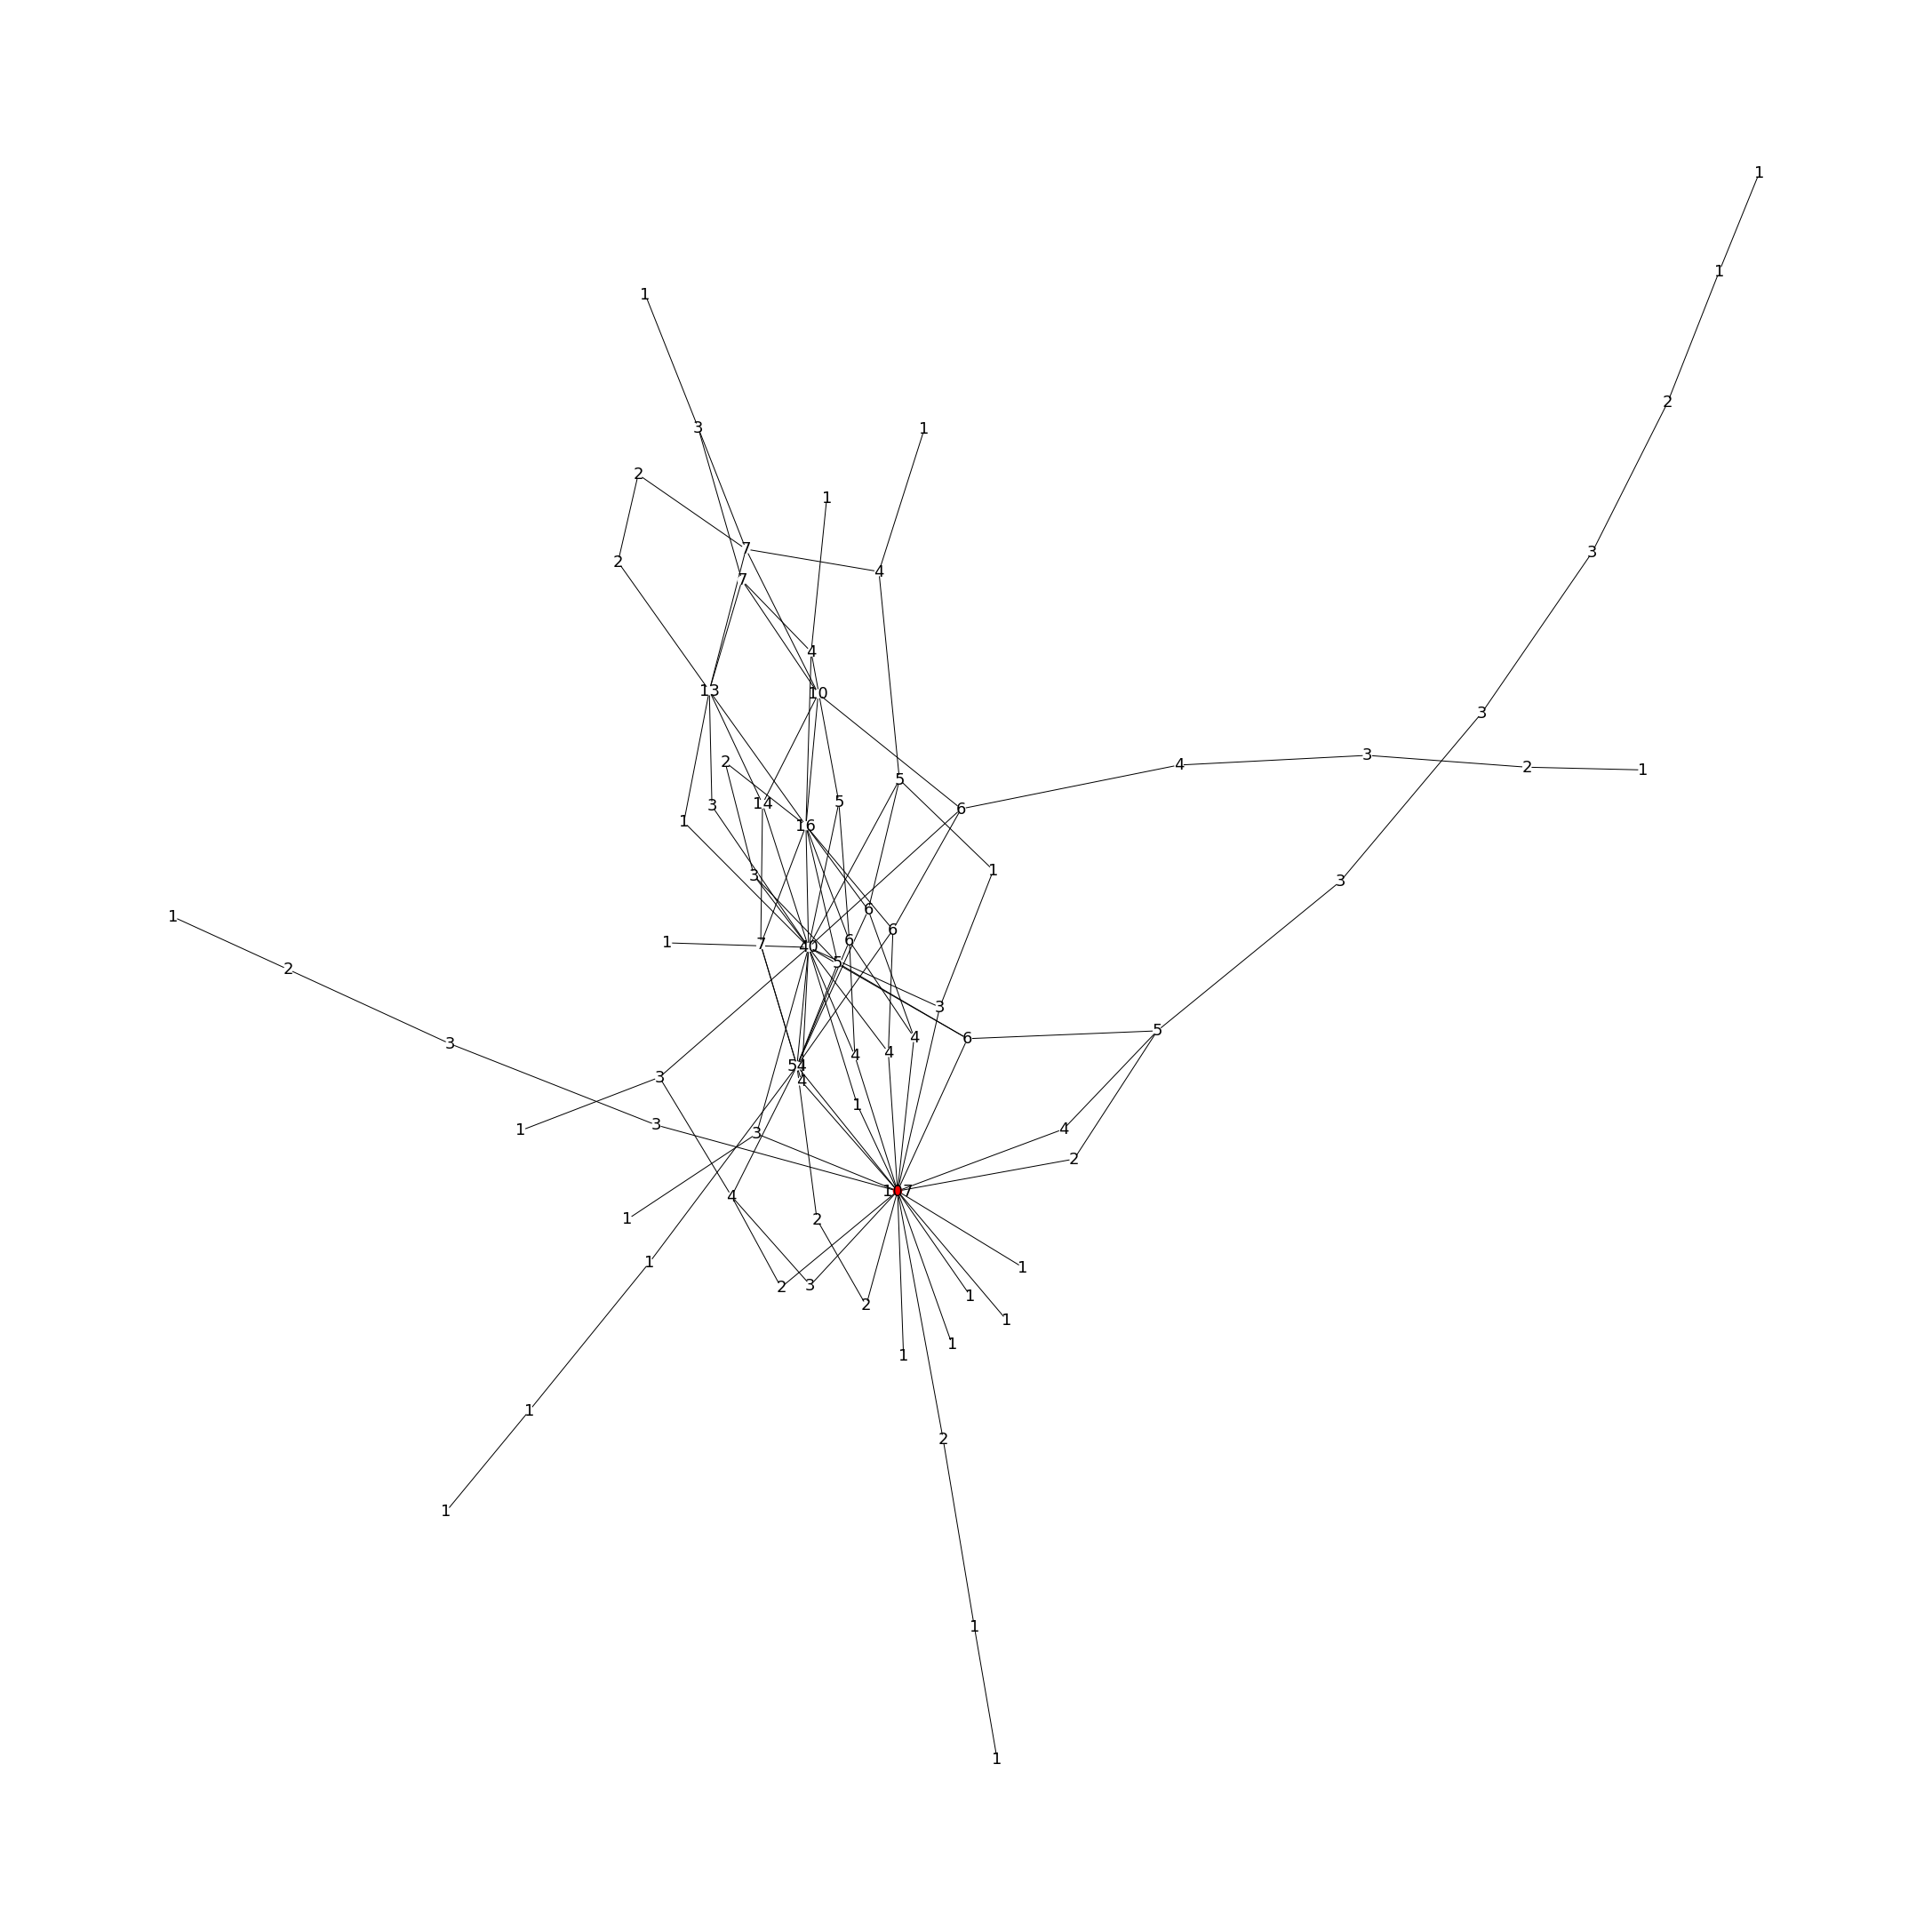

In [52]:
plt.figure(2,figsize=(30,30)) 
nx.draw(a_graph, node_color=color_map, with_labels = True, labels = nx.get_node_attributes(a_graph,'node_weight'), pos = a_pos, node_size = 90,font_size=18)
# plt.savefig("./dir_for_trees/Graph2.png", format="PNG")
plt.show()


In [ ]:
#construct dict to hold graphs; each graph starts with one of the 249 neurons. Thus, there will be 249 graphs
graphs = {}

with tqdm(total= len(all_pre_neurons)) as pbar:
    for seq in all_pre_neurons:
        pbar.update(1)
        #set up a dictionary to track which layer each element is in the tree in this seq
    neuron_occur_tracking = {}
    
    a_graph = None 
    #start looking at the curr neuron and the its next neuron
    seq_len = len(seq)
    for i in range(seq_len):
        if i == 0: 
            curr_neuron = seq[i]
            curr_neuron_num_rep = presypneuron_2_num_rep[curr_neuron]
            if not curr_neuron_num_rep in graphs:
                graphs[curr_neuron_num_rep] = nx.Graph()
                a_graph = graphs[curr_neuron_num_rep]
            else:
                a_graph = graphs[curr_neuron_num_rep]
                
        if i + 1 == seq_len:
            curr_neuron = seq[i]
            update_neuron_occur_tracking(neuron_occur_tracking, curr_neuron, i)
            curr_neuron_tag = str(presypneuron_2_num_rep[curr_neuron]) + '_' + str(neuron_occur_tracking[curr_neuron])
            if a_graph.has_node(curr_neuron_tag):
                if len(a_graph.nodes[curr_neuron_tag]) == 0:
                    a_graph.nodes[curr_neuron_tag]['node_weight'] = 1
                else:
                    a_graph.nodes[curr_neuron_tag]['node_weight'] += 1
            else: 
                a_graph.add_node(curr_neuron_tag)
                a_graph.nodes[curr_neuron_tag]['node_weight'] = 1
            
        if not (i + 1) >= seq_len:
            curr_neuron = seq[i]
            next_neuron = seq[i+1]
            update_neuron_occur_tracking(neuron_occur_tracking, curr_neuron, i)
            
            #naming: 1_2: neuron 1 appear at 2nd layer 
            #need to "decrorate the neuron_tags a little bit more e.g. 1_1, 1_2, and 1_3 and so on"
            curr_neuron_tag = str(presypneuron_2_num_rep[curr_neuron]) + '_' + str(neuron_occur_tracking[curr_neuron])
            next_neuron_tag = None 
            if curr_neuron == next_neuron:
                next_neuron_tag = str(presypneuron_2_num_rep[curr_neuron]) + '_' + str(neuron_occur_tracking[curr_neuron] + 1)
            else:
                next_neuron_tag = str(presypneuron_2_num_rep[next_neuron]) + '_' + str(neuron_occur_tracking[curr_neuron] + 1)

            #check with the edge that connects curr & next neuron is presence in the existing network
            #use function to encap below
            if a_graph.has_edge(curr_neuron_tag, next_neuron_tag):
                a_graph.nodes[curr_neuron_tag]['node_weight'] += 1
            else:
                a_graph.add_edge(curr_neuron_tag, next_neuron_tag)
                if a_graph.has_node(curr_neuron_tag):
                    if len(a_graph.nodes[curr_neuron_tag]) == 0:
                        a_graph.nodes[curr_neuron_tag]['node_weight'] = 1
                    else:
                        a_graph.nodes[curr_neuron_tag]['node_weight'] += 1
                else: 
                    a_graph.add_node(curr_neuron_tag)
                    a_graph.nodes[curr_neuron_tag]['node_weight'] = 1
            #use function to encap above

to save the graph fig reference to: https://stackoverflow.com/questions/22635538/in-networkx-cannot-save-a-graph-as-jpg-or-png-file

# dendrogram with Levinstein distance

In [54]:
import Levenshtein as levi

In [64]:
levi_dist_lst = []
with tqdm(total= (len(all_pre_neurons) - 1)) as pbar:
    for i in range(0, len(all_pre_neurons) - 1):
        pbar.update(1)
        curr_seq = str(all_pre_neurons[i])
        for j in range(i + 1, len(all_pre_neurons)):
            da_seq = str(all_pre_neurons[j])
            levi_dist_lst.append(levi.distance(curr_seq, da_seq))

print(len(levi_dist_lst))
levi_dist_array = np.array(levi_dist_lst)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 13622/13622 [20:39<00:00, 10.99it/s]


92786253


In [69]:
z = sp.cluster.hierarchy.linkage(levi_dist_array)
print(np.shape(z))

(13622, 4)


In [68]:
sp.cluster.hierarchy.dendrogram(z)

RecursionError: maximum recursion depth exceeded while getting the str of an object